# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score, roc_auc_score

c:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Pyro implementation

In [2]:
import pyro
from pyro import distributions as dist
import torch
from torch.distributions import constraints

pyro.enable_validation(True)


from collections import defaultdict
import matplotlib.pyplot as plt
import pyro
import torch
from tqdm.auto import tqdm


class GaussianNBClassifierPyro:
    def __init__(self, num_epochs=500, lr=1e-2):
        self._num_epochs = num_epochs
        self._lr = lr
        
        self._num_cls = None
        
        self._c_logits = None        
        self._num_probs = None
        
    def fit(self, X, y):
        pyro.clear_param_store()

        svi = pyro.infer.SVI(
            model=self._model,
            guide=self._guide,
            optim=pyro.optim.Adam({'lr': self._lr}),
            loss=pyro.infer.Trace_ELBO(),
        )
        losses = []
        with tqdm(range(self._num_epochs)) as pbar:
            for epoch in pbar:
                loss = svi.step(X, y)
                losses.append(loss)

                if epoch % 100 == 0:
                    print(f"Epoch: {epoch} Loss = {loss:.3f}")
        return losses

    def predict(self, X):
        pred = pyro.infer.Predictive(
            model=self._model,
            guide=self._guide,
            num_samples=1,
            return_sites=('logP(c|x)',),
        )
        log_pcx = pred(X)['logP(c|x)'].detach().squeeze(0).squeeze(0)
        y_pred = torch.argmax(log_pcx, dim=-1)
        return y_pred
    
    def _model(self, X, y=None):    
        if y is not None:  # training mode
            self._num_cls = max(y) + 1
            
            numerical_cols = X.columns.values
                    
            self._init_c_logits()
            self._init_num_params(X, numerical_cols)
            self._observe_numerical_features_given_classes(X, y)

        self._observe_classes(X, y)
        
    def _guide(self, X, y=None):
        pass  # This is meant to be an empty function
    
    def _init_c_logits(self):
        self._c_logits = pyro.param(
            'c_logits',
            torch.ones(self._num_cls).div(self._num_cls),
            constraint=constraints.simplex,
        )
        
    def _init_num_params(self, X, numerical_cols):
        self._num_probs = {
            col: {
                'mu': pyro.param(f'{col}_mu', torch.zeros(self._num_cls)),
                'sigma': pyro.param(f'{col}_sigma', torch.ones(self._num_cls)),
            }
            for col in numerical_cols
        }
        
    def _observe_numerical_features_given_classes(self, X, y):
        for c in range(self._num_cls):
            x_c = X[y==c]
            with pyro.plate(f'data-numerical-{c}', x_c.shape[0]):
                for nc, v in self._num_probs.items():
                    pyro.sample(
                        f'P(x_{nc}|c={c})', 
                        dist.Normal(v['mu'][c], v['sigma'][c]),
                        obs=torch.tensor(x_c[nc].values),
                    )
                    
    def _get_log_likelihood(self, X):
        log_lk = []
        
        for c in range(self._num_cls):
            lps = []
            
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items()
            ])

            log_lk.append(torch.stack(lps).sum(dim=0))
            
        return torch.stack(log_lk).t()
    
    def _observe_classes(self, X, y):
        if y is not None:
            y = torch.tensor(y)
        
        log_lk = self._get_log_likelihood(X)

        log_pcx = pyro.deterministic('logP(c|x)', self._c_logits.log() + log_lk)
        
        with pyro.plate('data-pred', X.shape[0]):    
            pyro.sample(
                'c',
                dist.Categorical(logits=log_pcx),
                obs=y,
            )

# PGMPY implementation

In [3]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator


class NaiveBayesPGMPY:
    def __init__(self, features: list):
        self.model = BayesianModel()
        for feature in features:
            self.model.add_edge('label', feature)


    def fit(self, X_train, y_train):
        data = X_train.copy()
        data['label'] = y_train
        self.model.fit(data, estimator=MaximumLikelihoodEstimator)

    def predict(self, X_test):
        return self.model.predict(X_test)

# Cannabis

In [4]:
np.random.seed(seed=123)
pyro.set_rng_seed(2)

## Read data

In [5]:
cannabis = pd.read_csv("data/cannabis_preprocessed.csv")

In [6]:
cannabis.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
       'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
       'Alcohol', 'Amphetamine', 'AmylNitrite', 'Benzodiazepine', 'Caffeine',
       'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
       'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', 'Nicotine', 'VSA',
       'Cannabis', 'Usage'],
      dtype='object')

In [7]:
human_features = ["Age", "Gender", "Education", "Country", "Ethnicity", "Nscore",  "Escore", "Oscore",
           "Ascore", "Cscore", "Impulsive", "SS"]
all_features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
       'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
       'Alcohol', 'Amphetamine', 'AmylNitrite', 'Benzodiazepine', 'Caffeine',
       'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
       'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', 'Nicotine', 'VSA']

target = 'Cannabis'

In [8]:
df_train = cannabis[cannabis.Usage == "Train"]
df_test  = cannabis[cannabis.Usage == "Test"]

In [9]:
# change features depending on which one you want to use
features = human_features
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [10]:
le= preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [11]:
f1_scores = []
roc_auc_scores = []

In [12]:
def calculate_roc_auc(y_test, y_pred):
    test_arr = np.asarray(y_test).reshape(len(y_test), 1)
    pred_arr = np.asarray(y_pred).reshape(len(y_pred), 1)
    enc = preprocessing.OneHotEncoder()
    test_arr = enc.fit_transform(test_arr).toarray()
    pred_arr = enc.transform(pred_arr).toarray()
    return roc_auc_score(test_arr, pred_arr, multi_class="ovr", average="macro")



## Sklearn

In [13]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       186
           1       0.34      0.34      0.34       143
           2       0.78      0.65      0.71       237

    accuracy                           0.61       566
   macro avg       0.58      0.59      0.58       566
weighted avg       0.62      0.61      0.61       566



In [14]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       186
           1       0.38      0.24      0.29       143
           2       0.75      0.76      0.75       237

    accuracy                           0.63       566
   macro avg       0.58      0.59      0.57       566
weighted avg       0.61      0.63      0.61       566



In [15]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
clf = MultinomialNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.85      0.68       186
           1       0.00      0.00      0.00       143
           2       0.69      0.82      0.75       237

    accuracy                           0.63       566
   macro avg       0.42      0.56      0.48       566
weighted avg       0.47      0.63      0.54       566



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
clf = ComplementNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.92      0.68       186
           1       0.00      0.00      0.00       143
           2       0.74      0.78      0.76       237

    accuracy                           0.63       566
   macro avg       0.43      0.57      0.48       566
weighted avg       0.49      0.63      0.54       566



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


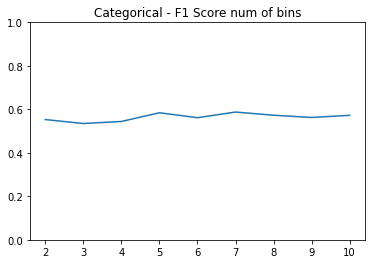

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       186
           1       0.40      0.25      0.31       143
           2       0.76      0.73      0.75       237

    accuracy                           0.64       566
   macro avg       0.59      0.60      0.59       566
weighted avg       0.62      0.64      0.62       566



In [18]:
f1s = []
roc_aucs = []

best_f1 = -1
best_roc_auc = -1
best_report = ""

for k in range(2, 11):
    est = preprocessing.KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform')

    X_train_discrete = X_train.copy()
    X_train_discrete[features] = est.fit_transform(X_train_discrete)

    X_test_discrete = X_test.copy()
    X_test_discrete[features] = est.transform(X_test_discrete) 
    clf = CategoricalNB()
    clf.fit(X_train_discrete, y_train)
    y_pred = clf.predict(X_test_discrete)    
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = calculate_roc_auc(y_test, y_pred)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    if f1 > best_f1:
        best_f1 = f1
        best_roc_auc = roc_auc
        best_report = classification_report(y_test, y_pred)
        
plt.title("Categorical - F1 Score num of bins")
plt.ylim([0, 1])
plt.plot(range(2,11),
        f1s)        
plt.show()        
    
    
f1_scores.append(best_f1)
roc_auc_scores.append(best_roc_auc)

print(best_report)

# Pyro

Epoch: 0 Loss = 23908.029



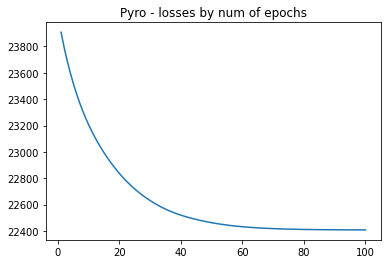

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       186
           1       0.37      0.31      0.34       143
           2       0.76      0.75      0.76       237

    accuracy                           0.64       566
   macro avg       0.59      0.60      0.59       566
weighted avg       0.63      0.64      0.63       566



In [19]:
clf = GaussianNBClassifierPyro(num_epochs=100)
losses = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.title("Pyro - losses by num of epochs")
plt.plot(range(1, 101), losses)        
plt.show() 

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

# PGMPY

100%|███████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 839.79it/s]


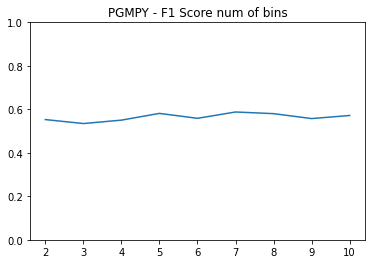

              precision    recall  f1-score   support

           0       0.62      0.81      0.70       186
           1       0.39      0.27      0.32       143
           2       0.76      0.73      0.74       237

    accuracy                           0.64       566
   macro avg       0.59      0.60      0.59       566
weighted avg       0.62      0.64      0.62       566



In [20]:
f1s = []
roc_aucs = []

best_f1 = -1
best_roc_auc = -1
best_report = ""

for k in range(2, 11):
    est = preprocessing.KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform')

    X_train_discrete = X_train.copy()
    X_train_discrete[features] = est.fit_transform(X_train_discrete)

    X_test_discrete = X_test.copy()
    X_test_discrete[features] = est.transform(X_test_discrete) 
    clf = NaiveBayesPGMPY(features)
    clf.fit(X_train_discrete, y_train)
    y_pred = clf.predict(X_test_discrete)    
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = calculate_roc_auc(y_test, y_pred)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    if f1 > best_f1:
        best_f1 = f1
        best_roc_auc = roc_auc
        best_report = classification_report(y_test, y_pred)

plt.title("PGMPY - F1 Score num of bins")
plt.ylim([0, 1])
plt.plot(range(2,11),
        f1s)        
plt.show()        
    
    
f1_scores.append(best_f1)
roc_auc_scores.append(best_roc_auc)

print(best_report)

# Scores

<BarContainer object of 7 artists>

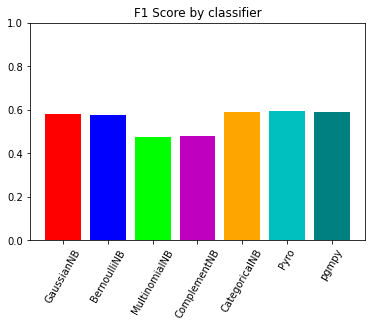

In [21]:
plt.title("F1 Score by classifier")
plt.ylim([0, 1])
plt.xticks(rotation=60)
plt.bar(["GaussianNB", "BernoulliNB", "MultinomialNB", "ComplementNB", "CategoricalNB", "Pyro", "pgmpy"],
        f1_scores,
        color=["r", "b", "lime", "m", "orange", "c",  "teal" ])

<BarContainer object of 7 artists>

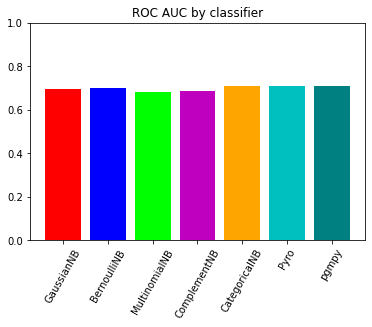

In [22]:
plt.title("ROC AUC by classifier")
plt.ylim([0, 1])
plt.xticks(rotation=60)
plt.bar(["GaussianNB", "BernoulliNB", "MultinomialNB", "ComplementNB", "CategoricalNB", "Pyro", "pgmpy"],
        roc_auc_scores,
        color=["r", "b", "lime", "m", "orange", "c",  "teal" ])

# Nicotine

In [23]:
np.random.seed(seed=123)
pyro.set_rng_seed(2)

## Read data

In [24]:
nicotine = pd.read_csv("data/nicotine_preprocessed.csv")

In [25]:
nicotine.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
       'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
       'Alcohol', 'Amphetamine', 'AmylNitrite', 'Benzodiazepine', 'Caffeine',
       'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin',
       'Ketamine', 'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', 'VSA',
       'Nicotine', 'Usage'],
      dtype='object')

In [26]:
human_features = ["Age", "Gender", "Education", "Country", "Ethnicity", "Nscore",  "Escore", "Oscore",
           "Ascore", "Cscore", "Impulsive", "SS"]
all_features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
       'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Cannabis',
       'Alcohol', 'Amphetamine', 'AmylNitrite', 'Benzodiazepine', 'Caffeine',
       'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
       'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', 'VSA']

target = 'Nicotine'

In [27]:
df_train = nicotine[nicotine.Usage == "Train"]
df_test  = nicotine[nicotine.Usage == "Test"]

In [28]:
# change features depending on which one you want to use
features = human_features
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [29]:
le= preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [30]:
f1_scores = []
roc_auc_scores = []

In [31]:
def calculate_roc_auc(y_test, y_pred):
    test_arr = np.asarray(y_test).reshape(len(y_test), 1)
    pred_arr = np.asarray(y_pred).reshape(len(y_pred), 1)
    enc = preprocessing.OneHotEncoder()
    test_arr = enc.fit_transform(test_arr).toarray()
    pred_arr = enc.transform(pred_arr).toarray()
    return roc_auc_score(test_arr, pred_arr, multi_class="ovr", average="macro")



## Sklearn

In [32]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.66      0.61       186
           1       0.28      0.23      0.25       117
           2       0.63      0.62      0.62       263

    accuracy                           0.55       566
   macro avg       0.50      0.50      0.50       566
weighted avg       0.54      0.55      0.54       566



In [33]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.68      0.59       186
           1       0.50      0.03      0.06       117
           2       0.59      0.72      0.65       263

    accuracy                           0.56       566
   macro avg       0.54      0.48      0.44       566
weighted avg       0.55      0.56      0.51       566



In [34]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
clf = MultinomialNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       186
           1       0.00      0.00      0.00       117
           2       0.53      0.86      0.66       263

    accuracy                           0.55       566
   macro avg       0.38      0.44      0.39       566
weighted avg       0.44      0.55      0.47       566



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
clf = ComplementNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.75      0.58       186
           1       0.00      0.00      0.00       117
           2       0.60      0.62      0.61       263

    accuracy                           0.53       566
   macro avg       0.36      0.45      0.40       566
weighted avg       0.43      0.53      0.47       566



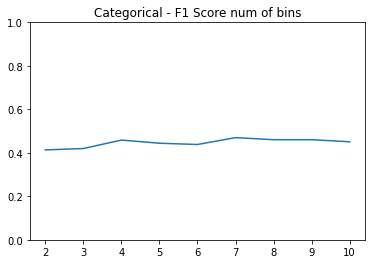

              precision    recall  f1-score   support

           0       0.54      0.71      0.62       186
           1       0.32      0.09      0.15       117
           2       0.62      0.68      0.65       263

    accuracy                           0.57       566
   macro avg       0.50      0.49      0.47       566
weighted avg       0.53      0.57      0.53       566



In [37]:
f1s = []
roc_aucs = []

best_f1 = -1
best_roc_auc = -1
best_report = ""

for k in range(2, 11):
    est = preprocessing.KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform')

    X_train_discrete = X_train.copy()
    X_train_discrete[features] = est.fit_transform(X_train_discrete)

    X_test_discrete = X_test.copy()
    X_test_discrete[features] = est.transform(X_test_discrete) 
    clf = CategoricalNB()
    clf.fit(X_train_discrete, y_train)
    y_pred = clf.predict(X_test_discrete)    
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = calculate_roc_auc(y_test, y_pred)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    if f1 > best_f1:
        best_f1 = f1
        best_roc_auc = roc_auc
        best_report = classification_report(y_test, y_pred)
        
plt.title("Categorical - F1 Score num of bins")
plt.ylim([0, 1])
plt.plot(range(2,11),
        f1s)        
plt.show()        
    
    
f1_scores.append(best_f1)
roc_auc_scores.append(best_roc_auc)

print(best_report)

# Pyro

Epoch: 0 Loss = 23908.029



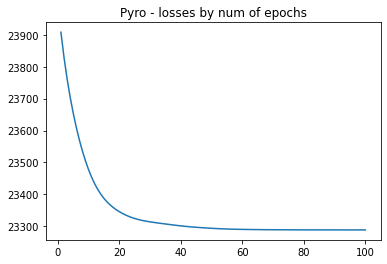

              precision    recall  f1-score   support

           0       0.56      0.65      0.60       186
           1       0.39      0.10      0.16       117
           2       0.61      0.74      0.67       263

    accuracy                           0.58       566
   macro avg       0.52      0.50      0.48       566
weighted avg       0.55      0.58      0.54       566



In [38]:
clf = GaussianNBClassifierPyro(num_epochs=100)
losses = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.title("Pyro - losses by num of epochs")
plt.plot(range(1, 101), losses)        
plt.show() 

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
roc_auc_scores.append(calculate_roc_auc(y_test, y_pred))

print(classification_report(y_test, y_pred))

# PGMPY

In [ ]:
f1s = []
roc_aucs = []

best_f1 = -1
best_roc_auc = -1
best_report = ""

for k in range(2, 11):
    est = preprocessing.KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform')

    X_train_discrete = X_train.copy()
    X_train_discrete[features] = est.fit_transform(X_train_discrete)

    X_test_discrete = X_test.copy()
    X_test_discrete[features] = est.transform(X_test_discrete) 
    clf = NaiveBayesPGMPY(features)
    clf.fit(X_train_discrete, y_train)
    y_pred = clf.predict(X_test_discrete)    
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = calculate_roc_auc(y_test, y_pred)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    if f1 > best_f1:
        best_f1 = f1
        best_roc_auc = roc_auc
        best_report = classification_report(y_test, y_pred)

plt.title("PGMPY - F1 Score num of bins")
plt.ylim([0, 1])
plt.plot(range(2,11),
        f1s)        
plt.show()        
    
    
f1_scores.append(best_f1)
roc_auc_scores.append(best_roc_auc)

print(best_report)

 25%|███████████████████▊                                                            | 96/387 [00:00<00:00, 705.82it/s]

# Scores

In [ ]:
plt.title("F1 Score by classifier")
plt.ylim([0, 1])
plt.xticks(rotation=60)
plt.bar(["GaussianNB", "BernoulliNB", "MultinomialNB", "ComplementNB", "CategoricalNB", "Pyro", "pgmpy"],
        f1_scores,
        color=["r", "b", "lime", "m", "orange", "c",  "teal" ])

In [ ]:
plt.title("ROC AUC by classifier")
plt.ylim([0, 1])
plt.xticks(rotation=60)
plt.bar(["GaussianNB", "BernoulliNB", "MultinomialNB", "ComplementNB", "CategoricalNB", "Pyro", "pgmpy"],
        roc_auc_scores,
        color=["r", "b", "lime", "m", "orange", "c",  "teal" ])